<a href="https://colab.research.google.com/github/BoonthichaSaejia/Homework_Datacamp_1/blob/master/Day35_Project_VII%20Stock%20Price%20Prediction/Day35_Project_VII_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import tensorflow as tf
from pandas_datareader import data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [2]:
# import all stock prices 
df = data.DataReader('tsla', data_source="yahoo", start='2018-01-01', end='2021-01-01')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2018-01-02 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       756 non-null    float64
 1   Low        756 non-null    float64
 2   Open       756 non-null    float64
 3   Close      756 non-null    float64
 4   Volume     756 non-null    float64
 5   Adj Close  756 non-null    float64
dtypes: float64(6)
memory usage: 41.3 KB


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,64.421997,62.200001,62.400002,64.106003,21761000.0,64.106003
2018-01-03,65.050003,63.110001,64.199997,63.450001,22607500.0,63.450001
2018-01-04,63.709999,61.136002,62.574001,62.924000,49731500.0,62.924000
2018-01-05,63.448002,62.400002,63.324001,63.316002,22956000.0,63.316002
2018-01-08,67.403999,63.099998,63.200001,67.281998,49297000.0,67.281998


In [3]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,666.090027,641.000000,642.98999,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.51001,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.00000,665.989990,22910800.0,665.989990
2020-12-30,696.599976,668.359985,672.00000,694.780029,42846000.0,694.780029
2020-12-31,718.719971,691.119995,699.98999,705.669983,49570900.0,705.669983


In [4]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000
mean,139.493304,132.466106,136.015424,136.354680,5.477074e+07,136.354680
std,149.812347,141.532618,145.765537,146.569721,3.379973e+07,146.569721
min,37.335999,35.397999,36.220001,35.793999,1.232800e+07,35.793999
25%,57.658999,55.446501,56.645000,56.833999,3.169138e+07,56.833999
50%,68.031002,65.551998,66.810001,66.847000,4.320325e+07,66.847000
75%,155.418003,143.320000,148.375996,149.819004,6.911812e+07,149.819004
max,718.719971,691.119995,699.989990,705.669983,3.046940e+08,705.669983


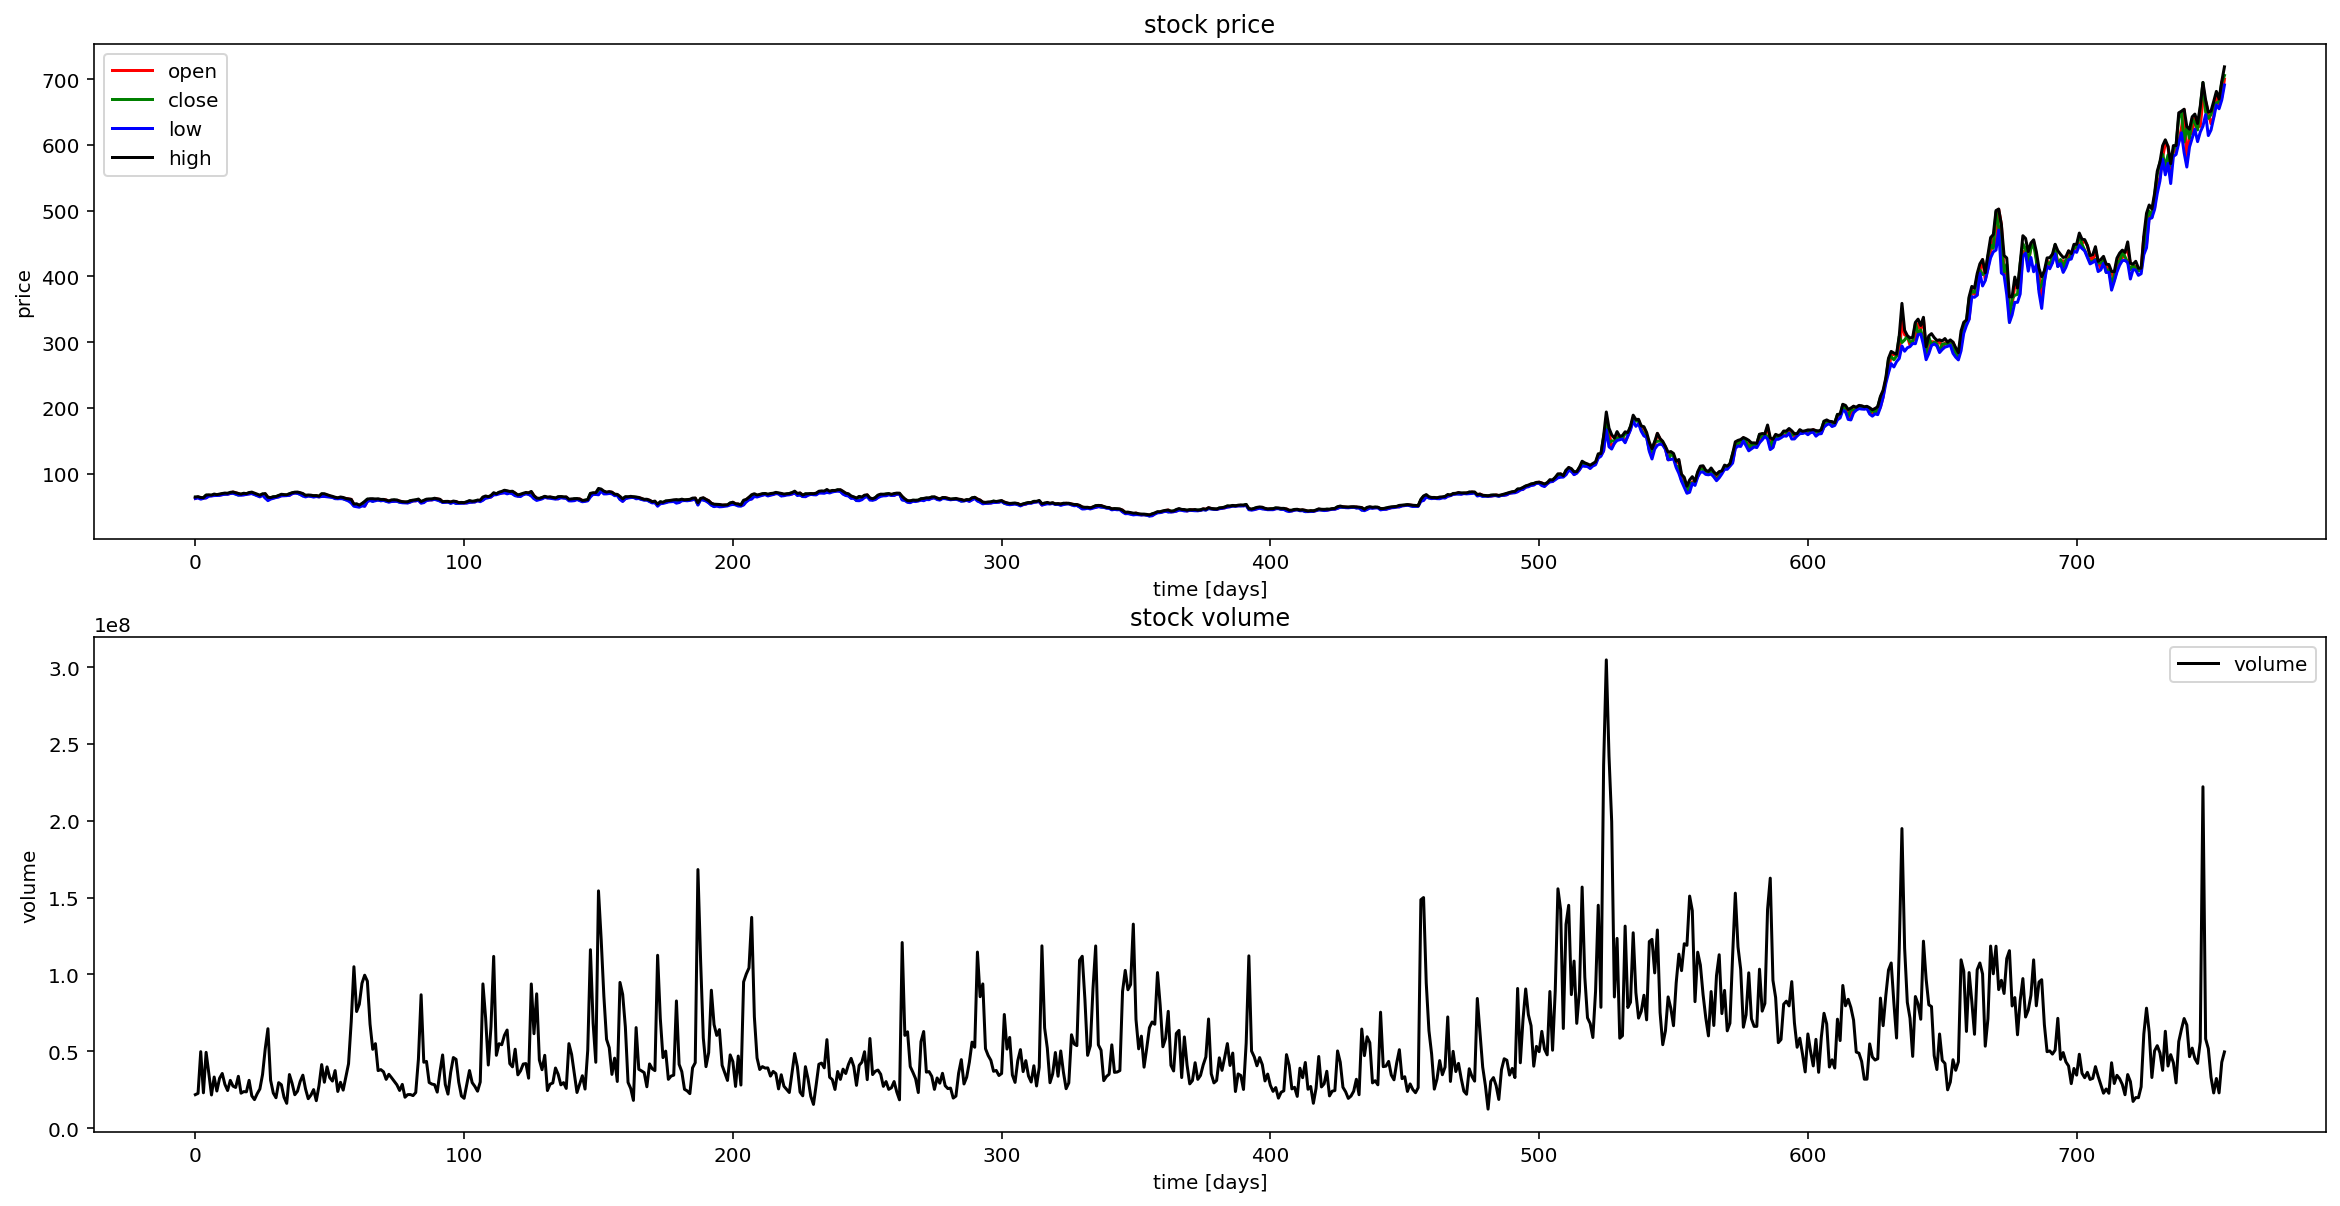

In [5]:
plt.figure(figsize=(20,10));
plt.subplot(2,1,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [6]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = np.array(stock) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df.copy()
df_stock.drop(['Volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.Columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print(x_train)

df_stock.Columns.values =  ['High', 'Low', 'Open', 'Close', 'Adj Close']
x_train.shape =  (588, 19, 9)
y_train.shape =  (588, 9)
x_valid.shape =  (74, 19, 9)
y_valid.shape =  (74, 9)
x_test.shape =  (74, 19, 9)
y_test.shape =  (74, 9)
[[[6.44219971e+01 6.22000008e+01 6.24000015e+01 ... 3.97514465e-02
   4.08740321e-02 4.22645456e-02]
  [6.50500031e+01 6.31100006e+01 6.41999969e+01 ... 4.06731089e-02
   4.22618152e-02 4.12852568e-02]
  [6.37099991e+01 6.11360016e+01 6.25740013e+01 ... 3.87065174e-02
   3.92513945e-02 4.05000354e-02]
  ...
  [6.98399963e+01 6.72799988e+01 6.96539993e+01 ... 4.77029093e-02
   4.86212147e-02 4.73729495e-02]
  [6.88000031e+01 6.71419983e+01 6.83000031e+01 ... 4.61766138e-02
   4.84107589e-02 4.89284610e-02]
  [7.01699982e+01 6.76559982e+01 6.79700012e+01 ... 4.81872204e-02
   4.91946276e-02 5.09228578e-02]]

 [[6.50500031e+01 6.31100006e+01 6.41999969e+01 ... 4.06731089e-02
   4.22618152e-02 4.12852568e-02]
  [6.37099991e+01 6.11360016e+01 6.25740013e+01 ..

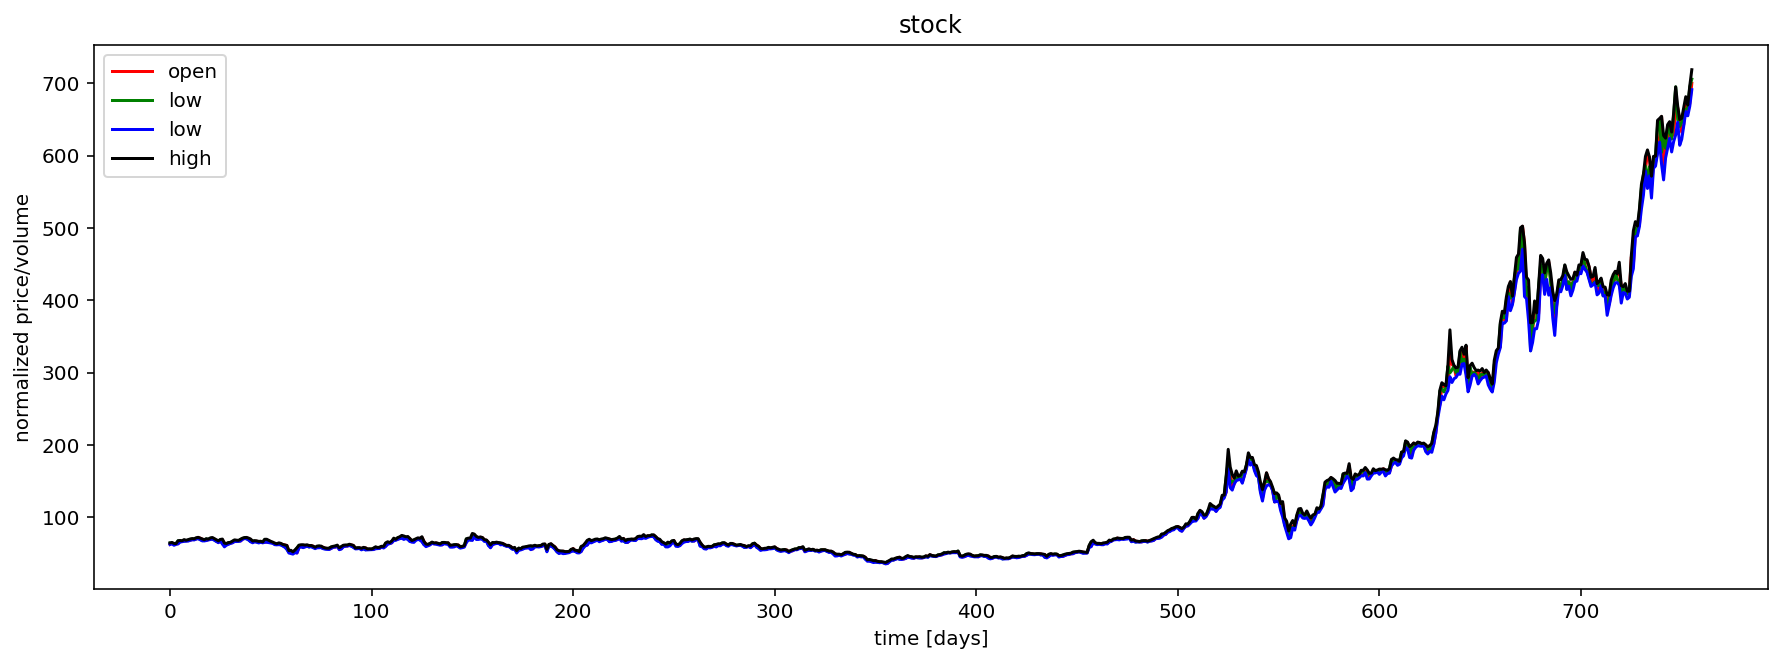

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.Open.values, color='red', label='open')
plt.plot(df_stock_norm.Close.values, color='green', label='low')
plt.plot(df_stock_norm.Low.values, color='blue', label='low')
plt.plot(df_stock_norm.High.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [8]:
from keras.models import Sequential
from keras.layers import Dropout,Dense,LSTM

In [9]:
x_train.shape

(588, 19, 9)

In [10]:
regressor = Sequential()
regressor.add(LSTM(units=200,return_sequences = True,input_shape=(19,9)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=200,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=200,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=200,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))

#output layer
regressor.add(Dense(9))

regressor.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [11]:
regressor.fit(x_train,y_train,epochs=200,batch_size=80)

Epoch 1/200
8/8 [==============================] - 10s 13ms/step - loss: 3455.4145
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 2988.5532
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 3010.6554
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 3019.1293
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 2855.5477
Epoch 6/200
8/8 [==============================] - 0s 12ms/step - loss: 2599.4352
Epoch 7/200
8/8 [==============================] - 0s 12ms/step - loss: 2682.9140
Epoch 8/200
8/8 [==============================] - 0s 12ms/step - loss: 2559.0439
Epoch 9/200
8/8 [==============================] - 0s 12ms/step - loss: 2828.9173
Epoch 10/200
8/8 [==============================] - 0s 13ms/step - loss: 2738.0710
Epoch 11/200
8/8 [==============================] - 0s 12ms/step - loss: 2522.0711
Epoch 12/200
8/8 [==============================] - 0s 12ms/step - loss: 2542.2991
Epoch 13/200

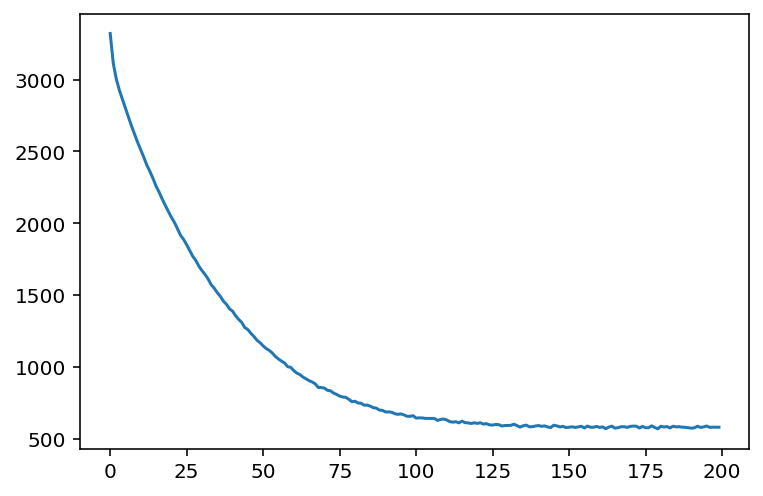

In [12]:
losses = regressor.history.history
losses = pd.DataFrame(losses)
losses['loss'].plot()